In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image

# ---------- PARAMETERS ----------
VIDEO_PATH = "/home/vedbhai/Downloads/Iodine Clock.mp4"
FRAMES_DIR = "frames"
EMBEDDING_PICKLE = "frame_data_with_embeddings.pkl"
REGRESSOR_WEIGHTS = "regressor.pth"
BATCH_SIZE = 32
LR = 1e-3
NUM_EPOCHS = 20

# ---------- STEP 1: EXTRACT FRAMES & METADATA ----------
os.makedirs(FRAMES_DIR, exist_ok=True)
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
interval = int(fps * 0.5)  # every 0.5 sec of video time
slowdown_factor = 3        # real_time = video_time / slowdown_factor

metadata = []
frame_idx = 0
saved_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_idx % interval == 0:
        video_time = frame_idx / fps
        real_time = video_time / slowdown_factor
        filename = f"frame_{saved_idx:03d}_t{real_time:.2f}s.jpg"
        path = os.path.join(FRAMES_DIR, filename)
        cv2.imwrite(path, frame)
        metadata.append({
            "frame_filename": filename,
            "video_time": video_time,
            "real_time": real_time
        })
        saved_idx += 1
    frame_idx += 1
cap.release()

# Add time_left to metadata
if metadata:
    total_real = metadata[-1]["real_time"] # Assuming the last frame as reaction getting completed.
    for entry in metadata:
        tl = total_real - entry["real_time"]
        entry["time_left"] = max(0.0, tl)
else:
    raise RuntimeError("No frames saved; metadata empty.")

# ---------- STEP 2: COMPUTE CNN EMBEDDINGS ----------
# Load pretrained ResNet18 & strip classification head
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Generate embeddings
for entry in metadata:
    img_path = os.path.join(FRAMES_DIR, entry["frame_filename"])
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = resnet(tensor).view(1, -1).squeeze().numpy()
    entry["cnn_embedding"] = feat

# Build DataFrame and save
df = pd.DataFrame(metadata)
df.rename(columns={"frame_filename": "filename"}, inplace=True)
df.to_pickle(EMBEDDING_PICKLE)

# ---------- STEP 3: TRAIN PyTorch REGRESSOR HEAD ----------
# Define model
class TimeRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.head(x)

# Prepare dataset
X = torch.from_numpy(np.stack(df["cnn_embedding"].values)).float()
y = torch.from_numpy(df["time_left"].values).float().unsqueeze(1)
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Instantiate
reg_model = TimeRegressor()
optimizer = optim.Adam(reg_model.parameters(), lr=LR)
criterion = nn.MSELoss()

# Train loop
reg_model.train()
for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    for bx, by in loader:
        optimizer.zero_grad()
        preds = reg_model(bx)
        loss = criterion(preds, by)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * bx.size(0)
    avg = total_loss / len(loader.dataset)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {avg:.4f}")

# Save weights
torch.save(reg_model.state_dict(), REGRESSOR_WEIGHTS)

# ---------- STEP 4: INFERENCE FUNCTION ----------
# Reload trained head
reg_model = TimeRegressor()
reg_model.load_state_dict(torch.load(REGRESSOR_WEIGHTS))
reg_model.eval()

# Predict helper
def predict_time_remaining(image_path):
    img = Image.open(image_path).convert("RGB")
    tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = resnet(tensor).view(1, -1)
        pred = reg_model(feat).item()
    return round(pred, 2)

Epoch 1/20 - Loss: 200.9850
Epoch 2/20 - Loss: 90.6553
Epoch 3/20 - Loss: 79.6684
Epoch 4/20 - Loss: 69.5395
Epoch 5/20 - Loss: 51.2684
Epoch 6/20 - Loss: 46.1660
Epoch 7/20 - Loss: 37.2938
Epoch 8/20 - Loss: 29.5725
Epoch 9/20 - Loss: 24.0531
Epoch 10/20 - Loss: 17.9842
Epoch 11/20 - Loss: 13.9528
Epoch 12/20 - Loss: 10.2545
Epoch 13/20 - Loss: 7.9738
Epoch 14/20 - Loss: 6.2551
Epoch 15/20 - Loss: 5.1260
Epoch 16/20 - Loss: 4.5559
Epoch 17/20 - Loss: 4.0254
Epoch 18/20 - Loss: 3.7219
Epoch 19/20 - Loss: 3.3536
Epoch 20/20 - Loss: 3.1927


In [2]:
import cv2
import os
import pandas as pd
import numpy as np

# === CONFIG ===
video_path = "/home/vedbhai/Downloads/Iodine Clock.mp4"
fps_extract_interval = 0.5  # already saved every 0.5s
slowdown_factor = 3
OUTPUT_DIR = "frames_inbetween"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Load video ===
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
Duration = total_frames / fps

# === Generate set of timestamps that were already saved ===
already_extracted_times = set()
t = 0.0
while t <= Duration:
    already_extracted_times.add(round(t, 2))
    t += fps_extract_interval

frame_idx = 0
saved_idx = 0
metadata = []

# === Loop through frames ===
while True:
    ret, frame = cap.read()
    if not ret:
        break

    video_time = frame_idx / fps
    rounded_time = round(video_time, 2)

    if frame is not None and rounded_time not in already_extracted_times:
        real_time = video_time / slowdown_factor
        filename = f"frame_{saved_idx:03d}_t{real_time:.2f}s.jpg"
        save_path = os.path.join(OUTPUT_DIR, filename)
        cv2.imwrite(save_path, frame)

        metadata.append({
            "frame_filename": filename,
            "video_time": round(video_time, 2),
            "real_time": round(real_time, 2)
        })

        saved_idx += 1

    frame_idx += 1

cap.release()

# === Save metadata as CSV ===
df = pd.DataFrame(metadata)
df.to_csv(os.path.join(OUTPUT_DIR, "inbetween_metadata.csv"), index=False)

print("✅ In-between frames extracted and metadata saved.")


✅ In-between frames extracted and metadata saved.


In [ ]:
# Example usage
if __name__ == "__main__":
    test_image = '/home/vedbhai/Downloads/frames_inbetween/frame_2568_t29.15s.jpg'
    print("Predicted time remaining:", predict_time_remaining(test_image), "seconds")

Predicted time remaining: 1.7 seconds


In [21]:
import os
ans = list()

def process_frame(frame_path):
    print(frame_path)
    ans.append(predict_time_remaining(frame_path))

def process_all_frames(folder_path):
    # get a sorted list of all .jpg files
    for fname in sorted(os.listdir(folder_path)):
        if not fname.lower().endswith(".jpg"):
            continue
        full_path = os.path.join(folder_path, fname)
        process_frame(full_path)

if __name__ == "__main__":
    process_all_frames("frames_inbetween")


frames_inbetween/frame_000_t0.01s.jpg
frames_inbetween/frame_001_t0.02s.jpg
frames_inbetween/frame_002_t0.03s.jpg
frames_inbetween/frame_003_t0.04s.jpg
frames_inbetween/frame_004_t0.06s.jpg
frames_inbetween/frame_005_t0.07s.jpg
frames_inbetween/frame_006_t0.08s.jpg
frames_inbetween/frame_007_t0.09s.jpg
frames_inbetween/frame_008_t0.10s.jpg
frames_inbetween/frame_009_t0.11s.jpg
frames_inbetween/frame_010_t0.12s.jpg
frames_inbetween/frame_011_t0.13s.jpg
frames_inbetween/frame_012_t0.14s.jpg
frames_inbetween/frame_013_t0.16s.jpg
frames_inbetween/frame_014_t0.18s.jpg
frames_inbetween/frame_015_t0.19s.jpg
frames_inbetween/frame_016_t0.20s.jpg
frames_inbetween/frame_017_t0.21s.jpg
frames_inbetween/frame_018_t0.22s.jpg
frames_inbetween/frame_019_t0.23s.jpg
frames_inbetween/frame_020_t0.24s.jpg
frames_inbetween/frame_021_t0.26s.jpg
frames_inbetween/frame_022_t0.27s.jpg
frames_inbetween/frame_023_t0.28s.jpg
frames_inbetween/frame_024_t0.29s.jpg
frames_inbetween/frame_025_t0.30s.jpg
frames_inbet

In [17]:
import matplotlib.pyplot as plt

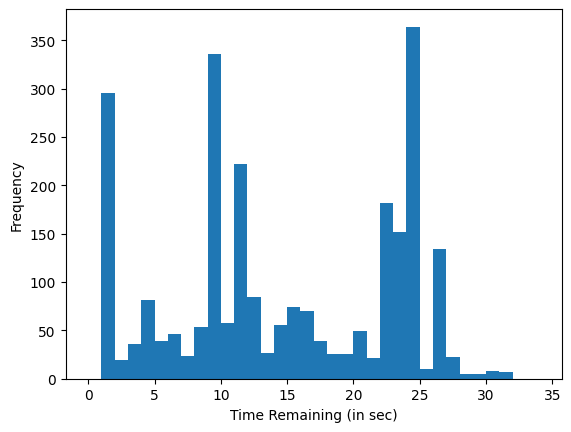

In [26]:
plt.hist(ans,bins = (np.arange(35)))
plt.xlabel('Time Remaining (in sec)')
plt.ylabel('Frequency')
plt.show()